# Packages

In [1]:
# Helpful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import split_vectorize
import base_models
import neural_net

from IPython.display import display, HTML

# Get Data

Choose how many rows of data you want to work with by filling in the n value below.

In [2]:
n = 100000

Uncomment the line below to create a new data file with a random sample of `n` articles. Otherwise, skip to the next cell to import an existing file with `n` articles.

In [3]:
# THIS CODE BLOCK CAN TAKE A LONG TIME TO RUN... SKIP IT BY LOADING AN EXISTING FILE INSTEAD
# %run parse_corpus.py $n

In [4]:
df = pd.read_csv('data/nyt_corpus_'+str(n)+'.csv')
df.shape
df.head(3)

,abstract,author_info,copyright_holder,copyright_year,descriptor,desk,full_text,general_descriptor,headline,id,...,print_page_number,print_section,publication_day_of_month,publication_day_of_week,publication_month,publication_year,series_name,taxonomic_classifier,title,types_of_material
0,"Corel Corp, Ottawa-based software company, re...",NaN,The New York Times,1998.0,NaN,Business/Financial Desk,"The Corel Corporation, an Ottawa-based softwa...","['Company Reports', 'Computer Software', 'Copy...","Corel, a Rival Of Microsoft, Had a Bad Year",989253,...,3.0,D,21.0,Wednesday,1.0,1998.0,NaN,"['Top/News/Technology', 'Top/News/Business', '...","Corel, a Rival Of Microsoft, Had a Bad Year",NaN
1,"New York State Legislature, ending annual ses...",NaN,The New York Times,1998.0,NaN,Westchester Weekly Desk,STATE legislators ended their annual session ...,"['Budgets and Budgeting', 'Finances']",Most of County's Wish List Denied,1027868,...,7.0,14WC,28.0,Sunday,6.0,1998.0,NaN,"['Top/News/New York and Region', 'Top/News/New...",Most of County's Wish List Denied,NaN
2,NaN,NaN,The New York Times,2005.0,NaN,Classified,"CARLSON -- Kathleen Ann. Died on January 30, ...",NaN,"Paid Notice: Deaths CARLSON, KATHLEEN ANN",1647142,...,25.0,G,3.0,Thursday,2.0,2005.0,NaN,['Top/Classifieds/Paid Death Notices'],"Paid Notice: Deaths CARLSON, KATHLEEN ANN",['Paid Death Notice']


### Possible Model Outputs

There are multiple columns that could be used as the target variable in classification models. I will use `desk` since it has the lowest percentage of nulls and it never assigns multiple labels to an article.

In [5]:
df[['desk','general_descriptor','online_sections','taxonomic_classifier']][-5:]

,desk,general_descriptor,online_sections,taxonomic_classifier
99995,Financial Desk,"['Mergers, Acquisitions and Divestitures', 'Fi...",Business,['Top/News/Business']
99996,Metropolitan Desk,"['Robberies and Thefts', 'Stadiums and Arenas'...",New York and Region,"['Top/News/New York and Region', 'Top/News/Spo..."
99997,Editorial Desk,"['Ethics', 'Reform and Reorganization', 'Presi...",Opinion,"['Top/Opinion', 'Top/Opinion/Opinion', 'Top/Ne..."
99998,Connecticut Weekly Desk,NaN,New York and Region,"['Top/News/New York and Region', 'Top/News/New..."
99999,Home Desk,"['Jewels and Jewelry', 'Trade Shows and Fairs']",Home and Garden; Style,"['Top/Features/Home and Garden', 'Top/Features..."


Percentage of nulls for each of the possible label columns:

In [6]:
(n - df[['desk','general_descriptor','online_sections','taxonomic_classifier']].count()) / n

desk                    0.00339
general_descriptor      0.21148
online_sections         0.02267
taxonomic_classifier    0.01465
dtype: float64

# Preprocess Data

Uncomment the line below to run pre-processing on the parsed data file. Otherwise, skip to the next cell to import the existing preprocessed file.

In [7]:
# THIS CODE BLOCK CAN TAKE A LONG TIME TO RUN... SKIP IT BY LOADING AN EXISTING FILE INSTEAD
# %run preprocessing.py $n

In [8]:
df_final = pd.read_csv('data/nyt_corpus_cleaned_'+str(n)+'.csv')
print(df_final.shape)
df_final.head()

(100000, 6)


,desk,full_text,lead_paragraph,headline,nouns,lemmas
0,business & financial,"the corel corporation , an ottawa - based soft...","the corel corporation , an ottawa - based soft...","corel , a rival of microsoft , had a bad year",corel corporation ottawa software company batt...,"the corel corporation , an ottawa - base softw..."
1,westchester weekly,state legislators ended their annual session e...,state legislators ended their annual session e...,most of county 's wish list denied,state legislators session month county wishes ...,state legislator end their annual session earl...
2,classified,"carlson -- kathleen ann . died on january 30 ,...","carlson -- kathleen ann . died on january 30 ,...","paid notice : deaths carlson , kathleen ann",carlson ann sloan kettering hospital year batt...,"carlson -- kathleen ann . die on january 30 , ..."
3,society,"judy ball morrill , a daughter of dewitt c . m...","judy ball morrill , a daughter of dewitt c . m...","judy morrill , randall taylor",judy ball morrill daughter c morrill southbury...,"judy ball morrill , a daughter of dewitt c . m..."
4,sports,baseball american league tampa bay devil rays ...,baseball american league tampa bay devil rays ...,transactions,baseball league tampa bay devil rays roy silve...,baseball american league tampa bay devil ray -...


The table below shows some examples of how the `desk` variable is cleaned.

In [9]:
label_transform = pd.concat([df_final.desk, df.desk], axis=1)
label_transform.columns = ['desk_cleaned', 'desk']
label_transform.groupby(['desk_cleaned','desk']).size().reset_index(name='cnt').set_index(['desk_cleaned','desk'])[:20]

cnt
desk_cleaned               desk                                      
2005: the year in pictures 2005: The Year In Pictures               1
a nation challenged        A Nation Challenged                      5
art & ideas/arts & leisure Art & Ideas/Cultural Desk                1
arts & leisure             Arts & Ideas/Cultural Desk             200
                           Arts & Leisure Desk                    405
                           Arts and Leisure Desk                 1499
                           Arts and Leisure Desk Desk               1
                           Cultural Desk                         2215
                           Cultural Desk;                           1
                           Cultural desk                            1
                           Leisure/Weekend Desk                   604
                           Movies, Performing Arts/Weekend Desk   754
                           Museums                                 14
                           The Arts/Cultural Desk                2045
                           The Arts\Cultural Desk                   1
                           Weekend Desk                          1002
                           Weekend DeskWeekend Desk                 5
book review                Book Review Desk                      1750
                           Book Review Dest                         1
boston 2004                Boston 2004                              2

### Train/Dev/Test Split and TF-IDF Vectorize

Here I create an object for each model input:

1. Full text
2. Lead paragraph
3. Headlines
4. Nouns
5. Lemmas

Throughout the rest of notebook, I will attach various statistics and models to each object.

/Users/carmen/Documents/NLP/w266-final-project/split_vectorize.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = self.df[[self.articles, self.labels]][self.df[self.articles].notnull()][self.df[self.labels].notnull()]


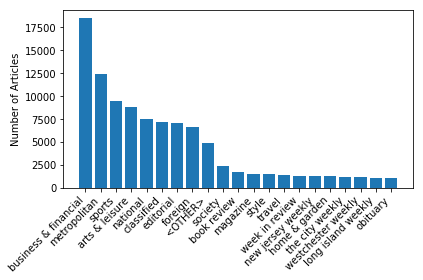

In [10]:
reload(split_vectorize)
rand_seed = 102 # Random number to feed in so all models will assign same articles to train/dev/test sets

# Create object for each of the model inputs
full_text = split_vectorize.SplitVectorize(df_final, 'full_text', 'Full Text')
lead_para = split_vectorize.SplitVectorize(df_final, 'lead_paragraph', 'Lead Paragraph')
headlines = split_vectorize.SplitVectorize(df_final, 'headline', 'Headlines')
nouns = split_vectorize.SplitVectorize(df_final, 'nouns', 'Nouns Only')
lemmas = split_vectorize.SplitVectorize(df_final, 'lemmas', 'Lemmatized')

all_inputs = [full_text, lead_para, headlines, nouns, lemmas]

# Split into train/test data and TF-IDF vectorize
for x in all_inputs:
    x.train_test_split(rand_seed)
    x.tfidf_vectorize()

Percentage of articles NOT in the `<OTHER>` category:

In [11]:
for x in all_inputs:
    print('{}: {:.1%}'.format(x.name_, x.df[x.df.desk != '<OTHER>'].groupby('desk').count().sum()[0] / x.df.groupby('desk').count().sum()[0]))

Full Text: 95.1%


Key statistics for each type of data. Note the number of articles for each model input varies because sometimes certain inputs have missing data. However, the same articles are assigned to training/dev/test data for each input.

In [12]:
html = '<table><th>Article Type</th><th>Total Articles</th><th>Training Articles</th><th>Training Words</th><th>% Training Words</th>'
html += '<th>Avg. Words per Training Article</th><th>Training Vocab Size</th><th>% Training Vocab</th>'
html += '<th>Avg. Unique Words per Training Article</th><th>Dev Articles</th><th>Test Articles</th></tr>'

for x in all_inputs:
    total = x.tv_train.shape[0] + x.tv_dev.shape[0] + x.tv_test.shape[0]
    html += '<tr><td>{}</td><td>{:,}</td><td>{:,}</td><td>{:,}</td>'.format(x.name_, total, x.tv_train.shape[0], x.train_words_)
    html += '<td>{:.0%}</td><td>{:.0f}</td>'.format(x.train_words_/full_text.train_words_, x.train_avg_words_)
    html += '<td>{:,}</td><td>{:.0%}</td>'.format(x.train_vocab_size_, x.train_vocab_size_/full_text.train_vocab_size_)
    html += '<td>{:,.0f}</td><td>{:,}</td><td>{:,}</td></tr>'.format(x.train_avg_unq_words_, x.tv_dev.shape[0], x.tv_test.shape[0])

html += '</table>'
display(HTML(html))

Full Text,"98,636","73,990","49,702,797",100%,672,"258,837",100%,260,"4,959","19,687"


# Baseline Models

I use a Multinomial Naïve Bayes and Logistic Regression as simple baseline models. For each model and model input, I fit multiple models with different parameters values, and then optimize on the dev data. After finding the best models, I calculate the accuracy on the test data.

### Multinomial Naïve Bayes

Fit multiple MNB models on each of the model inputs, looking for the best value of `alpha`.

In [14]:
reload(base_models)
mnb = base_models.MultNB()

for x in all_inputs:
    mnb.test_models(x)

Graph the accuracy on the dev data for each of the models tested.

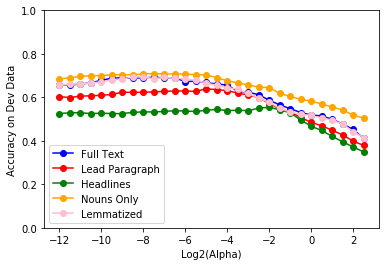

In [15]:
mnb_tables = []
for x in all_inputs:
    mnb_tables.append(x.mnb_accuracy_table_)

mnb.plot_accuracy(mnb_tables)

### Logistic Regression

Fit multiple LR models on each of the model inputs, looking for the best values of `C` and `penalty`.

In [16]:
reload(base_models)
lr = base_models.LogReg()

for x in all_inputs:
    lr.test_models(x)

Graph the accuracy on the dev data for each of the models tested.

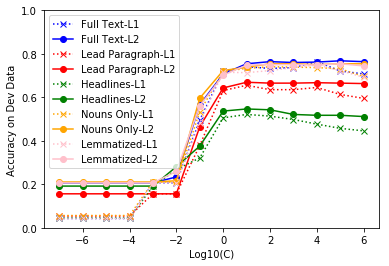

In [17]:
lr_tables = []
for x in all_inputs:
    lr_tables.append(x.lr_accuracy_table_)

lr.plot_accuracy(lr_tables)

### Key Statistics

For the best MNB and LR models for each of the possible inputs.

In [18]:
html = '<table><th>Model Input</th><th>MNB Parameters</th><th>MNB Dev Accuracy</th><th>MNB Test Accuracy</th>'
html += '<th>LR Parameters</th><th>LR Dev Accuracy</th><th>LR Test Accuracy</th>'

for x in all_inputs:
    alpha = 'alpha = 2^'+str(np.log2(x.best_mnb_model_.alpha))
    html += '<tr><td>{}</td><td>{}</td><td>{:.3f}</td><td>{:.3f}</td>'.format(x.name_, alpha, max(x.mnb_accuracy_table_.accuracy), x.best_mnb_model_.score(x.tv_test, x.test_labels))
    C = 'C = 10^'+str(np.log10(x.best_lr_model_.C))
    penalty = 'penalty = '+x.best_lr_model_.penalty
    html += '<td>{}</td><td>{:.3f}</td><td>{:.3f}</td></tr>'.format(C+'; '+penalty, max(x.lr_accuracy_table_.accuracy), x.best_lr_model_.score(x.tv_test, x.test_labels))

html += '</table>'
display(HTML(html))

Full Text,alpha = 2^-7.5,0.692,0.687,C = 10^5.0; penalty = l2,0.768,0.746
Lead Paragraph,alpha = 2^-5.0,0.639,0.623,C = 10^1.0; penalty = l2,0.669,0.665
Headlines,alpha = 2^-2.0,0.554,0.500,C = 10^1.0; penalty = l2,0.547,0.547
Nouns Only,alpha = 2^-7.5,0.710,0.664,C = 10^2.0; penalty = l2,0.754,0.697
Lemmatized,alpha = 2^-8.5,0.694,0.680,C = 10^5.0; penalty = l2,0.754,0.739


# Neural Network

1. This model uses GloVe word embeddings to initialize the word embedding matrix.
2. For each of the model inputs, it drops the bottom ***20%*** of words, since these tend to be misspellings or one-off words that don't contribute to helping the model learn the structure of each category.
3. For each of the model inputs, it pads each article to the smaller of:
    + The ***90th*** percentile of lengths for that input type
    + 500

In [13]:
reload(neural_net)
nn = neural_net.NeuralNets()

for x in all_inputs:
    nn.tokenize(x)
    nn.pad(x)
    nn.create_glove_matrix(x)
    
# Num Tokens:
# Drop 10%: 1238, 138, 11, 381, 1236
# Drop 20%: 1234, 137, 10, 375, 1232

# Padding:
#  90%: 1241,  140, 11,  381, 1236
# 100%: 7555, 5974, 55, 3296, 7556

Full Text:
	Training vocab size: 207,070
	90th percentile of length = 1,253 --> inputs padded to 500.
	Vocab reduced to 146,571 by padding operation (-29%)
	Training data shape: (73990, 500)
	Created GloVe matrix of 100-dimensional embeddings


In [14]:
for x in all_inputs:
    kernel_size = [4,3,2] if x == headlines else [20,5,2]
    nn.cnn(x, kernel_size=kernel_size)

Conv1D input: (None, 500)
Conv1D output: (None, 481, 4)
Conv1D input: (None, 500)
Conv1D output: (None, 477, 16)
Conv1D input: (None, 500)
Conv1D output: (None, 476, 32)
Pooling: (None, 32)
ReLU: (None, 100)
Softmax: (None, 21)
Epoch 1/5
73990/73990 [==============================] - 702s 9ms/step - loss: 1.7004 - acc: 0.4785
Epoch 2/5
73990/73990 [==============================] - 755s 10ms/step - loss: 1.1446 - acc: 0.6556
Epoch 3/5
 1504/73990 [..............................] - ETA: 12:14 - loss: 1.0109 - acc: 0.6935

KeyboardInterrupt: 

### Key Statistics

In [65]:
html = '<table><th>Model Input</th><th>Training Vocab</th><th>Padding Size</th>'
html += '<th>Vocab After Padding</th><th>Test Accuracy</th>'

for x in all_inputs:
    html += '<tr><td>{}</td><td>{:,}</td><td>{:,}</td>'.format(x.name_, int(round(x.train_vocab_size_ * 0.8, 0)), x.train_ids.shape[1])
    html += '<td>{:,}</td><td>{:.3f}</td></tr>'.format(x.nn_effective_vocab_, x.nn_accuracy_)

html += '</table>'
display(HTML(html))

Full Text,"70,033",500,"54,814",0.104
Lead Paragraph,"32,247",137,"28,113",0.030
Headlines,"8,920",10,"8,660",0.080
Nouns Only,"51,998",373,"49,192",0.101
Lemmatized,"60,518",500,"45,811",0.118


# Error Analysis

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
for x in [full_text]:#, lead_para, headlines, nouns, lemmas]:
    print('\n', x.name_, ':')
    print(classification_report(x.dev_labels, x.best_mnb_model_.predict(x.tv_dev)))
    print(confusion_matrix(x.dev_labels, x.best_mnb_model_.predict(x.tv_dev), labels=list(x.dev_labels.unique())))

In [ ]:
x.dev_labels.unique()